# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error
from fbprophet import Prophet
import datetime

# Load Data

In [2]:
#Data Loading
df = pd.read_pickle('./pkl_files/df_10.pkl')

In [3]:
df.head().T

Datetime,2014-01-01 07:40:00+00:00,2014-01-01 07:40:00+00:00,2014-01-01 07:50:00+00:00,2014-01-01 07:50:00+00:00,2014-01-01 08:00:00+00:00
PV Cell,A,B,B,A,B
Ambient Temperature [ºC],9.72037,9.72292,9.765,9.765,9.52833
Global Radiation [W/m2],7.54353,7.59508,15.7299,15.7299,39.1631
Diffuse Radiation [W/m2],7.21198,7.24733,13.8266,13.8266,26.8813
Ultraviolet [W/m2],0.894617,0.912466,1.37165,1.37165,2.09095
Wind Velocity [m/s],0.627778,0.61875,0.518333,0.518333,0.64
Wind Direction [º],281.16,281.888,334.33,334.33,314.493
Current DC [A],0.0961411,0.0416265,0.2465,0.29275,0.9385
Power DC [W],2.02627,0.939702,4.83639,6.86335,18.4311
Surface Temperature [ºC],9.46667,9.75,9.94,9.71,10.89


In [4]:
#df['dt'] = df.index

In [5]:
#mask_year = (df['dt'] >='2015-01-01') & (df['dt'] <'2015-05-01')

In [6]:
#df = df.loc[mask_year]

In [7]:
df = df.loc[df['PV Cell'] == "A"]

In [8]:
df.drop(columns=['Current DC [A]','Voltage DC [V]','PV Cell'],inplace=True)
#df.drop(columns=['Current DC [A]','Voltage DC [V]'],inplace=True)

In [9]:
df.describe()

,Ambient Temperature [ºC],Global Radiation [W/m2],Diffuse Radiation [W/m2],Ultraviolet [W/m2],Wind Velocity [m/s],Wind Direction [º],Power DC [W],Surface Temperature [ºC]
count,62854.000000,62854.000000,62854.000000,62854.000000,62854.000000,62854.000000,62854.000000,62854.000000
mean,20.835303,445.900985,122.339645,27.098394,2.587778,200.133790,98.548942,28.426338
std,5.575371,315.051945,98.919399,19.426670,1.202411,77.586552,70.531576,8.933510
min,3.519048,0.899312,1.605492,0.503170,0.000000,0.000000,0.000000,2.357143
25%,16.500000,152.755623,57.819850,9.635011,1.721667,130.369050,28.086418,21.150000
50%,20.865834,422.034085,95.134326,24.250744,2.565000,219.602652,98.027888,28.560000
75%,24.980000,713.722294,155.181215,42.972571,3.375000,259.526726,163.434625,35.560000
max,38.071668,1267.771204,698.234880,75.998830,9.435001,356.159480,266.294050,57.580000


In [10]:
df.dtypes

Ambient Temperature [ºC]    float64
Global Radiation [W/m2]     float64
Diffuse Radiation [W/m2]    float64
Ultraviolet [W/m2]          float64
Wind Velocity [m/s]         float64
Wind Direction [º]          float64
Power DC [W]                float64
Surface Temperature [ºC]    float64
dtype: object

In [11]:
df.dropna(thresh=3,inplace=True)

In [12]:
df.isnull().sum()

Ambient Temperature [ºC]    0
Global Radiation [W/m2]     0
Diffuse Radiation [W/m2]    0
Ultraviolet [W/m2]          0
Wind Velocity [m/s]         0
Wind Direction [º]          0
Power DC [W]                0
Surface Temperature [ºC]    0
dtype: int64

# Extract Power

In [13]:
Power = df["Power DC [W]"]

In [14]:
Power.head()

Datetime
2014-01-01 07:40:00+00:00     2.026272
2014-01-01 07:50:00+00:00     6.863350
2014-01-01 08:00:00+00:00    25.895750
2014-01-01 08:10:00+00:00    35.291137
2014-01-01 08:20:00+00:00    35.802737
Name: Power DC [W], dtype: float64

In [15]:
df.shape

(62854, 8)

In [16]:
#Drop power from df
df_m = df.drop(columns=["Power DC [W]"])

In [17]:
df_m.shape

(62854, 7)

In [18]:
df_m.head().T

Datetime,2014-01-01 07:40:00+00:00,2014-01-01 07:50:00+00:00,2014-01-01 08:00:00+00:00,2014-01-01 08:10:00+00:00,2014-01-01 08:20:00+00:00
Ambient Temperature [ºC],9.720370,9.765000,9.528333,9.348334,9.451668
Global Radiation [W/m2],7.543532,15.729948,39.163142,56.345415,73.218330
Diffuse Radiation [W/m2],7.211980,13.826647,26.881252,35.346479,49.791784
Ultraviolet [W/m2],0.894617,1.371647,2.090951,2.880174,3.937485
Wind Velocity [m/s],0.627778,0.518333,0.640000,0.970000,1.230000
Wind Direction [º],281.160176,334.330448,314.492646,302.054766,293.711586
Surface Temperature [ºC],9.466667,9.710000,10.370000,10.940000,11.170000


# Train/Test Split

Looking at different splits. 

In [19]:
len(df_m) * .7, len(df_m) * .3, len(df_m) * .8, len(df_m) * .2

(43997.799999999996, 18856.2, 50283.200000000004, 12570.800000000001)

Will do an 80/20 split due to abundance of data. 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="Power DC [W]"), 
                                                    df["Power DC [W]"], test_size=0.2, 
                                                    random_state=47)

In [21]:
X_train.shape, X_test.shape

((50283, 7), (12571, 7))

In [22]:
y_train.shape, y_test.shape

((50283,), (12571,))

In [23]:
X_train.dtypes

Ambient Temperature [ºC]    float64
Global Radiation [W/m2]     float64
Diffuse Radiation [W/m2]    float64
Ultraviolet [W/m2]          float64
Wind Velocity [m/s]         float64
Wind Direction [º]          float64
Surface Temperature [ºC]    float64
dtype: object

In [24]:
X_test.dtypes

Ambient Temperature [ºC]    float64
Global Radiation [W/m2]     float64
Diffuse Radiation [W/m2]    float64
Ultraviolet [W/m2]          float64
Wind Velocity [m/s]         float64
Wind Direction [º]          float64
Surface Temperature [ºC]    float64
dtype: object

In [25]:
#names_list = ['PV Cell']
#names_train = X_train[names_list]
#names_test = X_test[names_list]
#X_train.drop(columns=names_list, inplace=True)
#X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

((50283, 7), (12571, 7))

In [26]:
X_train.dtypes, X_test.dtypes

(Ambient Temperature [ºC]    float64
 Global Radiation [W/m2]     float64
 Diffuse Radiation [W/m2]    float64
 Ultraviolet [W/m2]          float64
 Wind Velocity [m/s]         float64
 Wind Direction [º]          float64
 Surface Temperature [ºC]    float64
 dtype: object,
 Ambient Temperature [ºC]    float64
 Global Radiation [W/m2]     float64
 Diffuse Radiation [W/m2]    float64
 Ultraviolet [W/m2]          float64
 Wind Velocity [m/s]         float64
 Wind Direction [º]          float64
 Surface Temperature [ºC]    float64
 dtype: object)

# Initial "Model" (the mean)

In [27]:
train_mean = y_train.mean()
train_mean

98.30564587981719

In [28]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[98.30564588]])

In [29]:
y_tr_pred_ = train_mean * np.ones(len(y_train))
y_tr_pred_[:5]

array([98.30564588, 98.30564588, 98.30564588, 98.30564588, 98.30564588])

In [30]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([98.30564588, 98.30564588, 98.30564588, 98.30564588, 98.30564588])

In [31]:
y_te_pred = train_mean * np.ones(len(y_test))

In [32]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0002958208648962124)

In [33]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(62.85695680827747, 63.1876378070895)

In [34]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(4967.416125124615, 5003.751457786205)

In [35]:
np.sqrt([mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)])

array([70.47989873, 70.73719996])

So using the mean, we are off by ~ 64.4 Watts when prediting power output, which would compound rather astoundingly for day/week prediction. 

# Initial (Actual) Models

We do not have missing data so skipping the fill/drop missing value step.

In [36]:
#X_train.drop(columns='PV Cell', inplace=True)
#X_test.drop(columns='PV Cell',inplace=True)

In [37]:
X_tr = X_train
X_te = X_test

## Scaling the data

In [38]:
#sc_X_tr = X_tr.loc[:,X_tr.columns != 'PV Cell']
#sc_X_te = X_te.loc[:,X_te.columns != 'PV Cell']

In [39]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

## Linear regresion model

In [40]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

In [41]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [42]:
lm_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
lm_r2

(0.8499285910209216, 0.8520278925825345)

In [43]:
lm_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
lm_mae

(19.819652859774223, 19.886763832394454)

In [44]:
lm_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
lm_mse

(745.4671368828452, 740.196682579006)

Note! We have not yet removed the voltage/current columns. This great fit is expected as current and voltage exactly explain power (Voltage*Current = Power) and as noted in prior step, current is HIGHLY correlated to Power. 

In [45]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [46]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [47]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [48]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [49]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x118e40790>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1, param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7]})

In [50]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [51]:
lr_grid_cv.best_params_

{'selectkbest__k': 7}

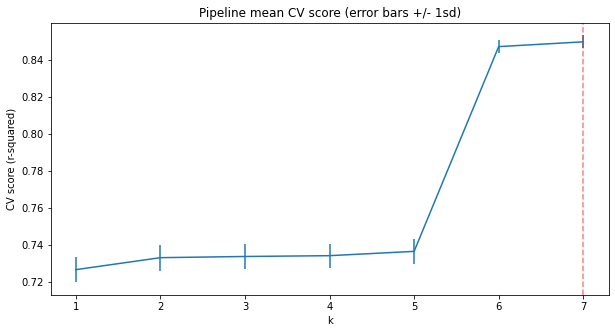

In [52]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [53]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [54]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

Global Radiation [W/m2]     85.256207
Surface Temperature [ºC]    27.684863
Wind Velocity [m/s]          1.830070
Diffuse Radiation [W/m2]     1.298509
Wind Direction [º]          -3.750840
Ultraviolet [W/m2]         -30.427005
Ambient Temperature [ºC]   -33.751300
dtype: float64

Insert notes/observations here. 

# Random Forest Model

In [55]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47,n_jobs=-1)
)

In [56]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=3)

In [57]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.92633858, 0.92647825, 0.92681082])

In [58]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.9265425494335503, 0.00019807700807893946)

#Note to self: need to change this. []
#n_est = [int(n) for n in np.logspace(start=1, stop=3, num=5)]
grid_params = {
        'randomforestregressor__n_estimators': [120,300,500,800,1200],
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

In [59]:
#rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=3, n_jobs=-1)

In [60]:
#rf_grid_cv.fit(X_train, y_train)

In [61]:
#rf_grid_cv.best_params_

In [62]:
#1200, mean, none is best

In [63]:
#Note to self: need to change this. []
#n_est = [int(n) for n in np.logspace(start=1, stop=3, num=5)]
#grid_params = {
#        'randomforestregressor__n_estimators': [800,1000,1200,1400,1600],
#        'standardscaler': [None],
#        'simpleimputer__strategy': ['mean']
#}
#grid_params

In [64]:
#rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=3, n_jobs=-1)

In [65]:
#rf_grid_cv.fit(X_train, y_train)

In [66]:
#rf_grid_cv.best_params_

In [67]:
#1400 best
#grid_params = {
#        'randomforestregressor__n_estimators': [1300,1400,1500],
#        'standardscaler': [None],
#        'simpleimputer__strategy': ['mean']
#}
#grid_params

In [68]:
#rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=3, n_jobs=-1)

In [69]:

#rf_grid_cv.fit(X_train, y_train)

In [70]:
#rf_grid_cv.best_params_

In [84]:
##### 1500 best; 1525 best; 1550 best; 1525>1550, 1530>1520, 1530>1540, 1530>1525. 1530 it is. 
grid_params = {
        'randomforestregressor__n_estimators': [1525,1530],
        'standardscaler': [None],
        'simpleimputer__strategy': ['mean']
}
grid_params

{'randomforestregressor__n_estimators': [1525, 1530],
 'standardscaler': [None],
 'simpleimputer__strategy': ['mean']}

In [85]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=3, n_jobs=-1)

In [86]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [1525, 1530],
                         'simpleimputer__strategy': ['mean'],
                         'standardscaler': [None]})

In [87]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 1530,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

In [99]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=3)

In [101]:
rf_best_scores = rf_best_cv_results['test_score'] 

In [103]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.9273619438125843, 0.00024953190954711947)

#1400 best
grid_params = {
        'randomforestregressor__n_estimators': [1300,1400,1500],
        'standardscaler': [None],
        'simpleimputer__strategy': ['mean']
}
grid_params

rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=3, n_jobs=-1)

rf_grid_cv.fit(X_train, y_train)

rf_grid_cv.best_params_

rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=3)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

np.mean(rf_best_scores), np.std(rf_best_scores)

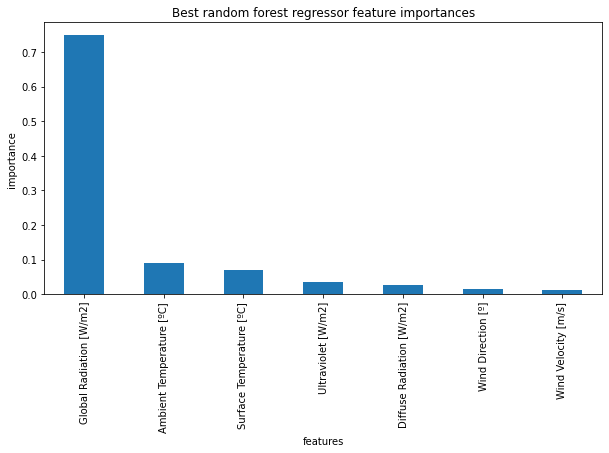

In [104]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar') 
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

# Model Performance

Linear Model Performance

In [89]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [90]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(19.827181706359386, 0.20477603098447625)

In [91]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

19.886763832394454

RF Model Performance

In [92]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)

In [93]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(11.998944154476446, 0.020757578712582443)

In [94]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

11.533793509973508

In [95]:
y_test.min(),y_test.max()

(0.0, 253.5785)

# Save the model

In [105]:
best_model = rf_grid_cv.best_estimator_
best_model.version = '3.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()
    
modelpath = './models'
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
pvmodel_path = os.path.join(modelpath, '4months_A_pv.pkl')
if not os.path.exists(pvmodel_path):
    with open(pvmodel_path, 'wb') as f:
        pickle.dump(best_model, f)

In [106]:
print(best_model)

Pipeline(steps=[('simpleimputer', SimpleImputer()), ('standardscaler', None),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=1530, n_jobs=-1,
                                       random_state=47))])
